# LLM-Powered Booking Analytics & QA System


### Objective

Build a system that ingests hotel booking data, extracts valuable insights, and supports retrieval-augmented question answering (RAG). The system should generate analytical reports as described below and allow users to query the data.

### Sections

•Data Loading

•Data Cleaning & Preprocessing

•Data Analysis & Visualization

•Exporting Processed Data


## Data Ingestion & Preprocessing


In [1]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("hotel_bookings.csv")

# Display basic info
print("Dataset Shape:", df.shape)
print(df.info())
print(df.head())

Dataset Shape: (119390, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  i

In [2]:
# Combine arrival date components into a single datetime column
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'] + '-' +
    df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d',
    errors='coerce'
)

In [3]:
# Convert reservation status date to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'], format='%d-%m-%y', errors='coerce')

In [5]:
# Handle missing values
df['children'] = df['children'].fillna(0)
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)
df['country'] = df['country'].fillna("Unknown")

In [6]:
# Total number of nights stayed (week + weekend)
df['total_stays'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']

In [7]:
# Calculate estimated revenue:
# Revenue = adr * total nights stayed.
# (Assuming each booking's revenue is approximated by the average daily rate times total nights.)
df['revenue'] = df['adr'] * df['total_stays']

In [8]:
# Display the updated dataframe structure
print("\nPreprocessed Data:")
print(df[['arrival_date', 'reservation_status_date', 'total_stays', 'revenue']].head())


Preprocessed Data:
  arrival_date reservation_status_date  total_stays  revenue
0   2015-07-01                     NaT            0      0.0
1   2015-07-01                     NaT            0      0.0
2   2015-07-01                     NaT            1     75.0
3   2015-07-01                     NaT            1     75.0
4   2015-07-01                     NaT            2    196.0


## Analytics and Visualization


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Owner\AppData\Local\Temp\ipykernel_18108\2747997703.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  revenue_trend = df.groupby(pd.Grouper(key='arrival_date', freq='M'))['revenue'].sum()


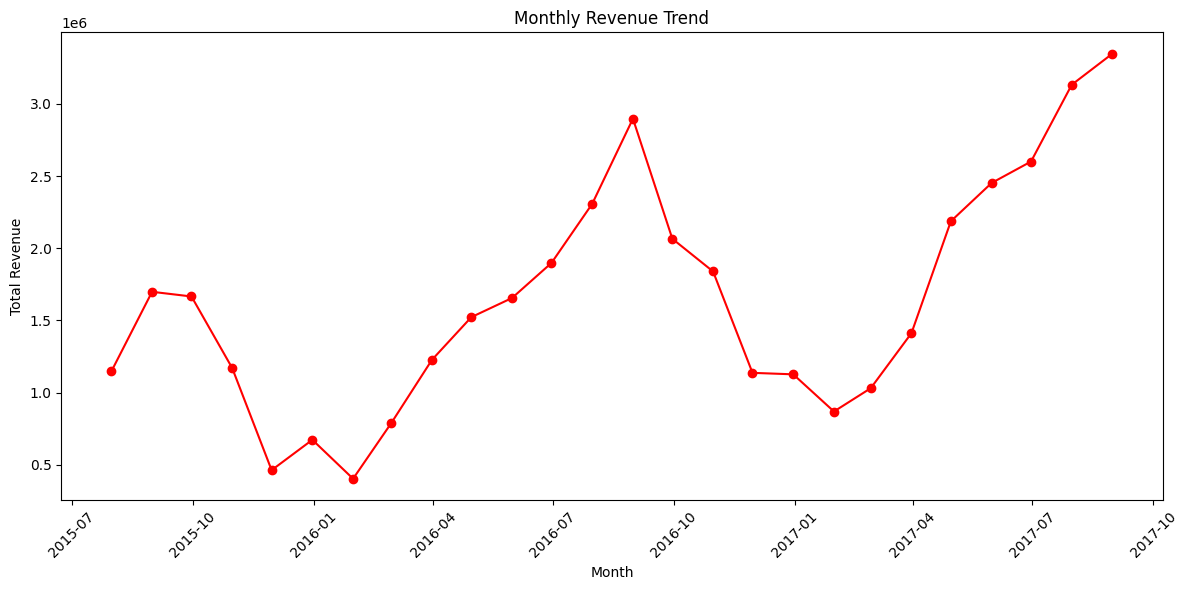

In [10]:
# Monthly revenue trend
revenue_trend = df.groupby(pd.Grouper(key='arrival_date', freq='M'))['revenue'].sum()

plt.figure(figsize=(12, 6))
plt.plot(revenue_trend.index, revenue_trend.values, marker='o', color='r')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

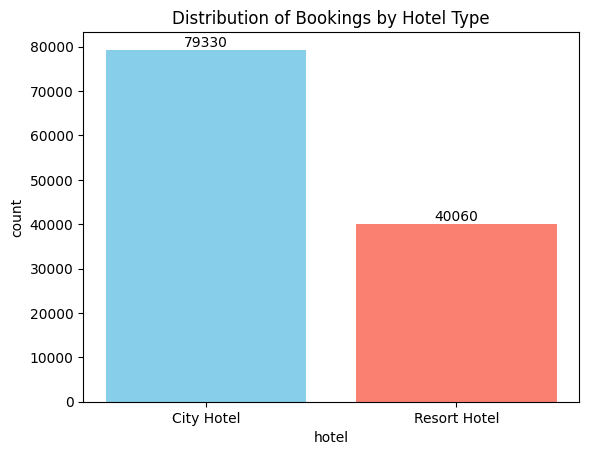

In [11]:
#Display the distribution of bookings by hotel type
value_counts = df['hotel'].value_counts()
hotels = list(value_counts.index)
values = list(value_counts.values)

plt.bar(hotels, values, color=['skyblue', 'salmon'])

for i in range(len(hotels)):
    plt.text(i, values[i], str(values[i]), ha='center', va='bottom')

plt.title('Distribution of Bookings by Hotel Type')
plt.xlabel('hotel')
plt.ylabel('count')
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_18108\480894156.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1631.33333333 1524.33333333 2994.33333333 2696.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),


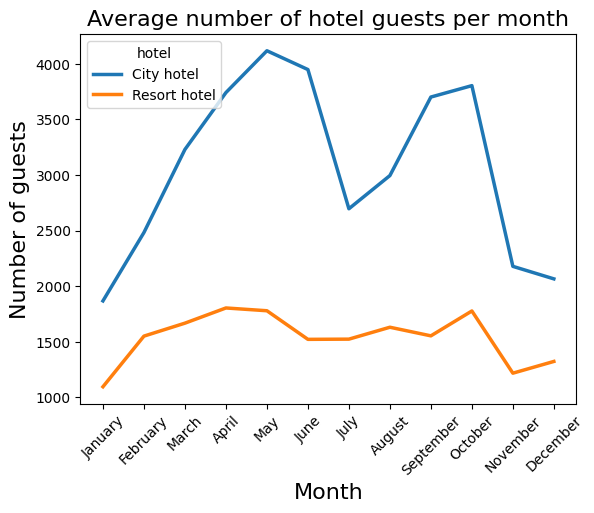

In [13]:
#Average number of guests per month
rh = df[df['hotel'] == 'Resort Hotel']
ch = df[df['hotel'] == 'City Hotel']

resort_guests_monthly = rh.groupby("arrival_date_month")["hotel"].count()
city_guests_monthly = ch.groupby("arrival_date_month")["hotel"].count()

resort_guest_data = pd.DataFrame({"month": list(resort_guests_monthly.index),
                    "hotel": "Resort hotel", 
                    "guests": list(resort_guests_monthly.values)})

city_guest_data = pd.DataFrame({"month": list(city_guests_monthly.index),
                    "hotel": "City hotel", 
                    "guests": list(city_guests_monthly.values)})

full_guest_data = pd.concat([resort_guest_data,city_guest_data], ignore_index=True)

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

full_guest_data["month"] = pd.Categorical(full_guest_data["month"], categories=ordered_months, ordered=True)

full_guest_data.loc[(full_guest_data["month"] == "July") | (full_guest_data["month"] == "August"),
                    "guests"] /= 3

full_guest_data.loc[~((full_guest_data["month"] == "July") | (full_guest_data["month"] == "August")),
                    "guests"] /= 2

sns.lineplot(x = "month", y="guests", hue="hotel", data=full_guest_data, 
             hue_order = ["City hotel", "Resort hotel"], size="hotel", sizes=(2.5, 2.5))

plt.title("Average number of hotel guests per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Number of guests", fontsize=16)
plt.show()

This data shows the number of reservations in two different types of hotels:

City Hotel: 79,330 reservations
Resort Hotel: 40,060 reservations


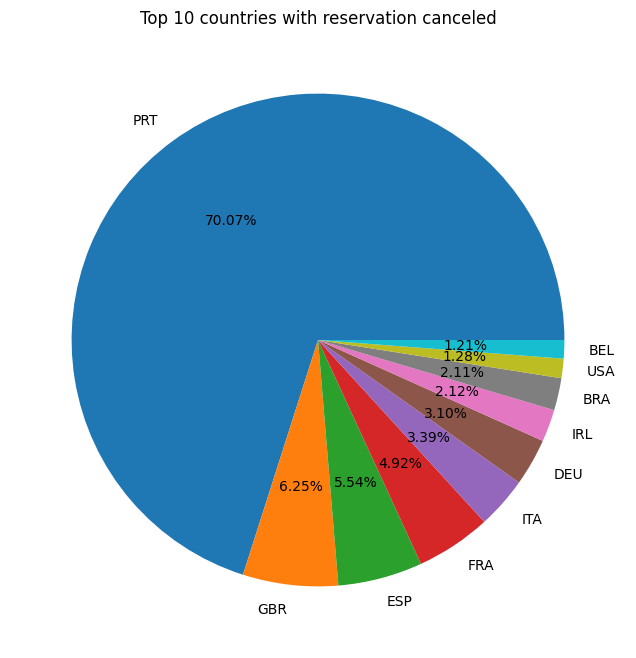

In [ ]:
#Top 10 countries with reservation canceled
cancelled_data = df[df['is_canceled'] == 1]
top_10_country = cancelled_data['country'].value_counts()[:10]

plt.figure(figsize=(8, 8))
plt.title('Top 10 countries with reservation canceled')
plt.pie(top_10_country, autopct='%.2f%%', labels=top_10_country.index) # added an extra % to the autopct so that the output is displayed as a percentage.
plt.show()

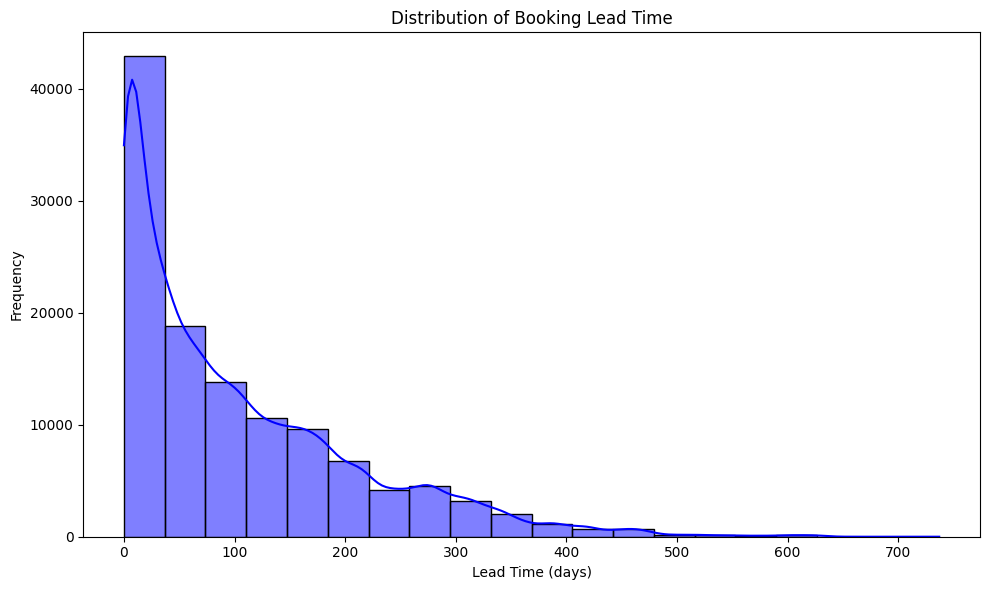

In [120]:
# Histogram of the lead times.

plt.figure(figsize=(10, 6))
sns.histplot(df['lead_time'], bins=20, kde=True, color='blue')
plt.title('Distribution of Booking Lead Time')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Average Revenue by Customer Type:
customer_type
Contract           451.196700
Transient          381.631057
Transient-Party    260.493376
Group              243.813328
Name: revenue, dtype: float64


C:\Users\Owner\AppData\Local\Temp\ipykernel_13460\576414849.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_revenue_by_customer.index, y=avg_revenue_by_customer.values, palette='rocket')


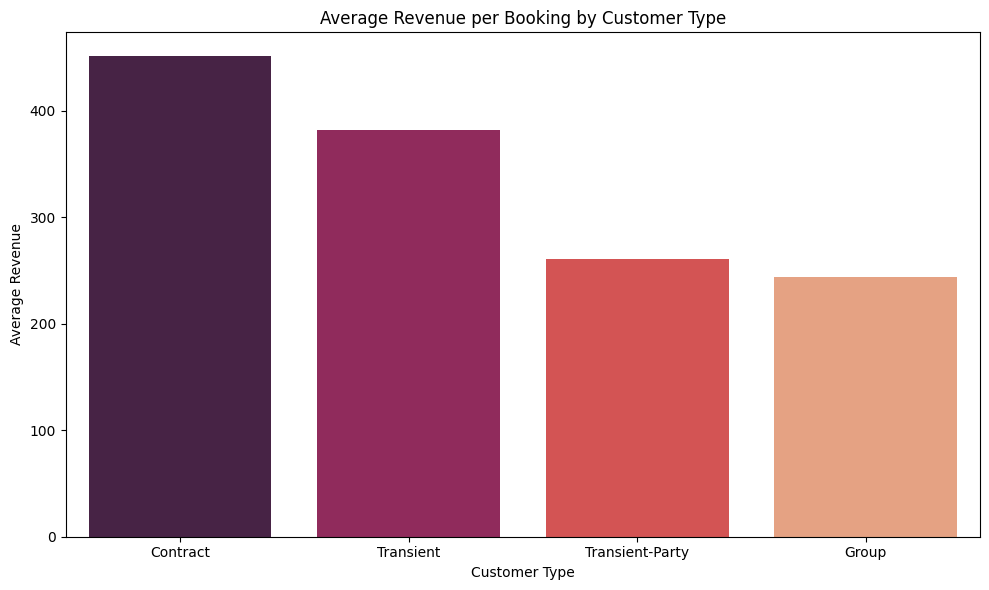

In [ ]:
# Group by customer_type and calculate average revenue
avg_revenue_by_customer = df.groupby('customer_type')['revenue'].mean().sort_values(ascending=False)
print("Average Revenue by Customer Type:")
print(avg_revenue_by_customer)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_revenue_by_customer.index, y=avg_revenue_by_customer.values, palette='rocket')
plt.title('Average Revenue per Booking by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Revenue')
plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_13460\709839958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adr_trend_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='M'), 'hotel'])['adr'].mean().reset_index()


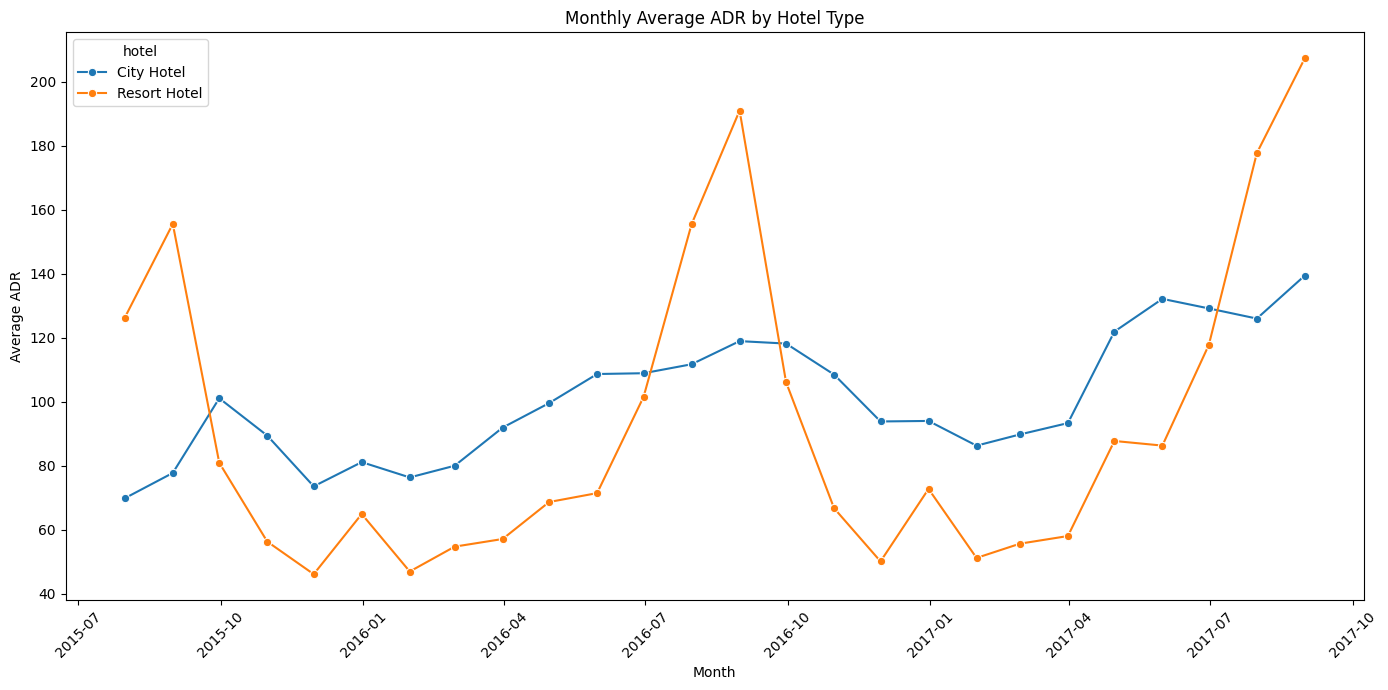

In [122]:
# Group by month and hotel type to calculate mean ADR
adr_trend_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='M'), 'hotel'])['adr'].mean().reset_index()

plt.figure(figsize=(14,7))
sns.lineplot(data=adr_trend_hotel, x='arrival_date', y='adr', hue='hotel', marker='o')
plt.title('Monthly Average ADR by Hotel Type')
plt.xlabel('Month')
plt.ylabel('Average ADR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

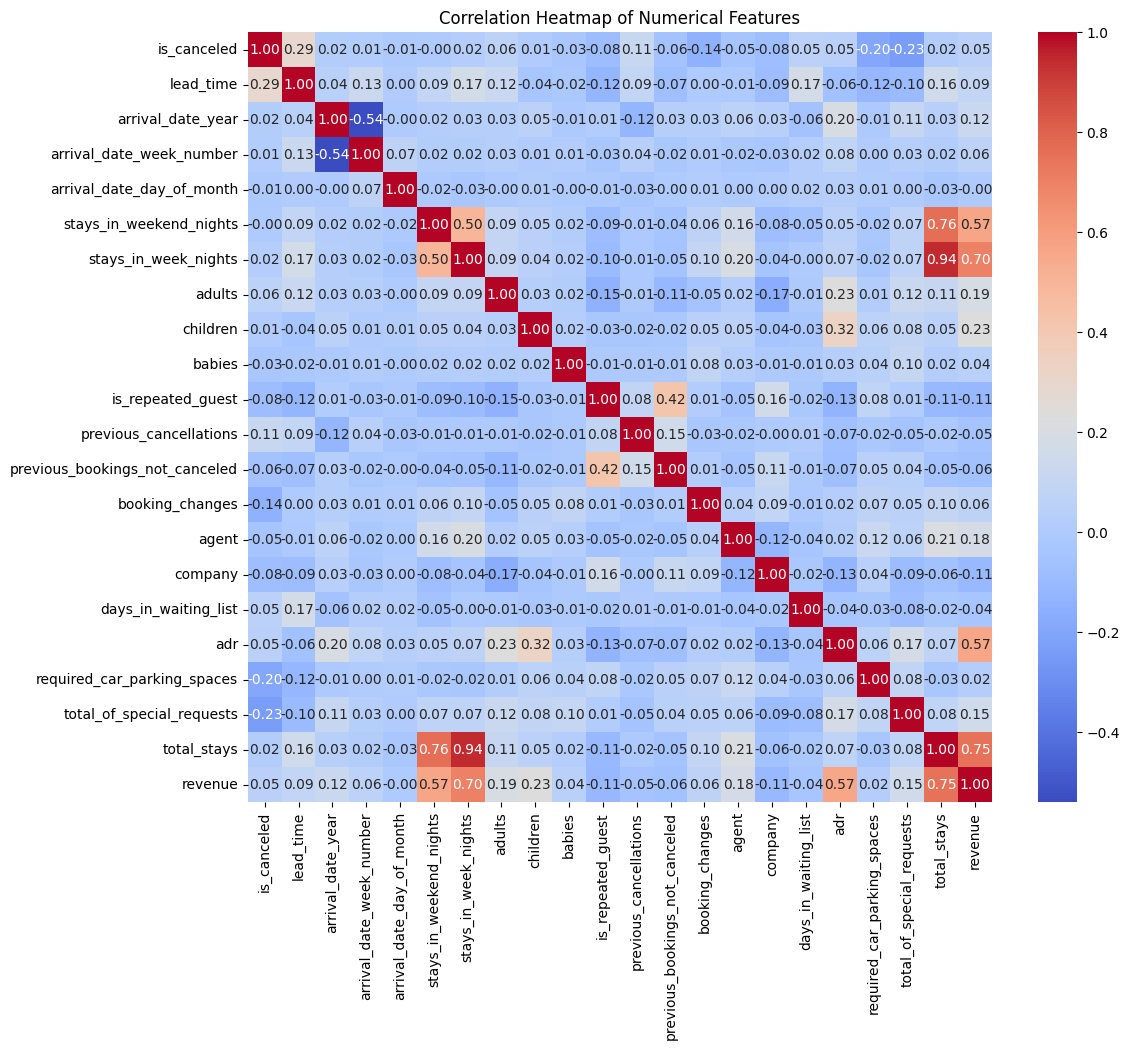

In [123]:
# Correlation Heatmap of Numerical Features
numeric_cols = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 10))
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

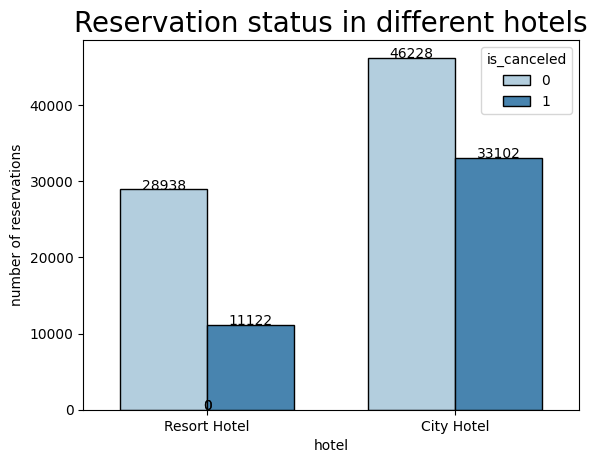

In [ ]:
# Reservation status in different hotels
ax1 = sns.countplot(x='hotel', hue='is_canceled', data=df, palette='Blues', edgecolor='k', width=0.7)
legend_labels, _ = ax1.get_legend_handles_labels()
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2.,
             height + 0.5,
             f'{int(height)}',
             ha='center')
plt.title('Reservation status in different hotels', size=20)
plt.xlabel('hotel')
plt.ylabel('number of reservations')
plt.show()

In [130]:
# is_canceled: 1 means canceled, 0 means not canceled.
total_bookings = len(df)
total_cancellations = df['is_canceled'].sum()
cancellation_rate = (total_cancellations / total_bookings) * 100

print(f"Overall Cancellation Rate: {cancellation_rate:.2f}%")

Overall Cancellation Rate: 37.04%


C:\Users\Owner\AppData\Local\Temp\ipykernel_13460\1017147133.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cancellation_by_month_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='M'), 'hotel'])['is_canceled'].mean().reset_index()


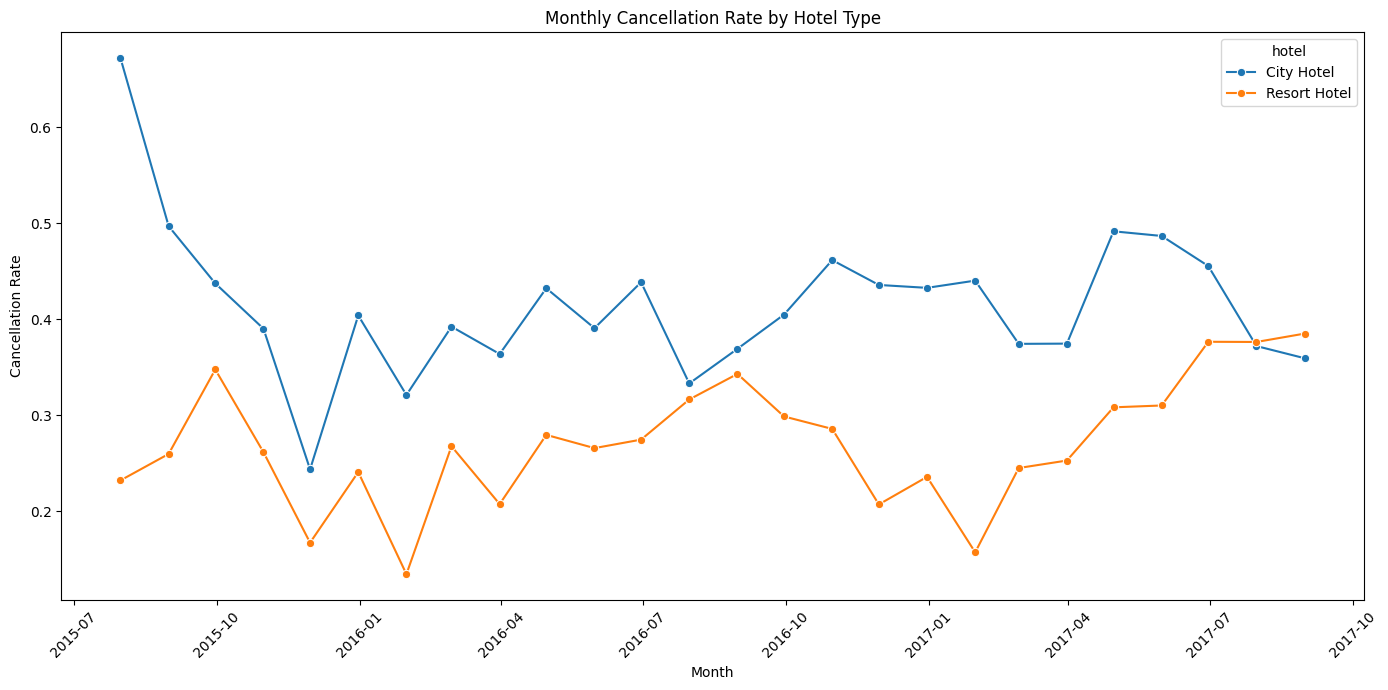

In [131]:
# Calculate monthly cancellation rate per hotel type (is_canceled is 1 for canceled, 0 for not canceled)
cancellation_by_month_hotel = df.groupby([pd.Grouper(key='arrival_date', freq='M'), 'hotel'])['is_canceled'].mean().reset_index()

plt.figure(figsize=(14,7))
sns.lineplot(data=cancellation_by_month_hotel, x='arrival_date', y='is_canceled', hue='hotel', marker='o')
plt.title('Monthly Cancellation Rate by Hotel Type')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

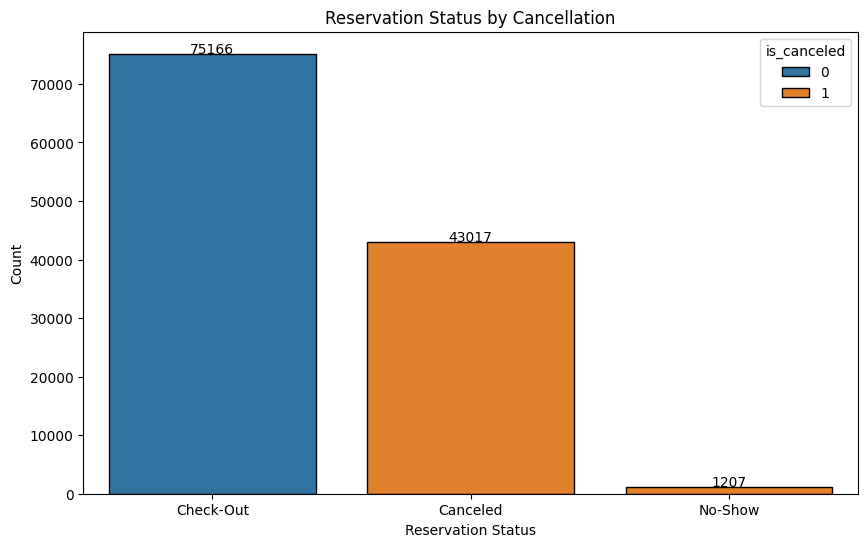

In [ ]:
#Reservation Status by Cancellation
res_df = df.groupby(["is_canceled", "reservation_status"]).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
plt.title('Reservation Status by Cancellation')
sns.barplot(x=res_df['reservation_status'], y=res_df['Count'], hue=res_df['is_canceled'], edgecolor='k')

for i in range(len(res_df)):
    plt.text(i, res_df['Count'][i] + 50, str(res_df['Count'][i]), ha='center')

plt.xlabel('Reservation Status')
plt.ylabel('Count')
plt.show()

---

## Export Processed Data


In [133]:
df.to_csv("hotel_bookings_preprocessed.csv", index=False)